In [1]:
import numpy as np
import shap
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.inspection import PartialDependenceDisplay
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix, roc_curve, auc, roc_auc_score, classification_report
import matplotlib.pyplot as plt
from imblearn.combine import SMOTETomek
from sklearn.model_selection import RandomizedSearchCV


d:\Ahmad Uzzam\personal\Harsh\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Reading the dataset

In [45]:
df = pd.read_excel(r'../data/2206MCPC_VA (1).xlsx')

In [46]:
df

,Age,Age Group,Ethnicity,Race,Clinic assigned to,Zip Code,City,Year,Text Follow up Prior Scheduling Completed PrEP Appointment,Call Follow up Prior Scheduling Completed PrEP Appointment,...,Month,Waiting time(Days),Time spent at clinic(Min),First Filled Date After Completed Appointment,First Shipped Date After Completed Appointment,Insurance Status(First Filled Date After Completed Appointment),Insurance Status Source(First Filled Date After Completed Appointment),Fill shipment waiting period,First Filled Drug Prescribed,First Filled Pharmacy used
0,22,18-24,Not Hispanic or Latino,White,MCPC West,37129,MURFREESBORO,2021,0,0,...,June,3.0,67.0,2021-06-08,2021-06-09,Insured,Active Insurance In bwell,1.0,DESCOVY TAB 30,Avita
1,38,35-44,Not Hispanic or Latino,Black,MCPC West,37205,NASHVILLE,2021,0,0,...,June,3.0,74.0,2021-06-15,2021-06-16,NaN,NaN,8.0,DESCOVY TAB 30,Avita
2,34,25-34,Not Hispanic or Latino,White,MCPC West,75204,DALLAS,2021,0,0,...,June,0.0,67.0,2021-06-10,2021-06-10,NaN,NaN,5.0,DESCOVY TAB 30,Avita
3,25,25-34,Puerto Rican,Native American,MCPC West,37211,NASHVILLE,2021,0,0,...,August,2.0,80.0,2022-06-01,2022-06-02,NaN,NaN,304.0,EMTRIC TENO TB200 300MG LAU30@,Avita
4,28,25-34,Not Hispanic or Latino,White,MCPC West,37207-4842,NASHVILLE,2021,0,0,...,August,0.0,54.0,NaT,NaT,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10413,23,18-24,Not Hispanic or Latino,White,MCPC East,37130,MURFREESBORO,2024,0,0,...,March,4.0,24.0,NaT,NaT,NaN,NaN,NaN,NaN,NaN
10414,26,25-34,Not Hispanic or Latino,White,MCPC East,37203,NASHVILLE,2024,0,0,...,March,1.0,78.0,2024-03-28,2024-04-02,Insured,Insured Fill,8.0,DESCOVY TAB 30,Avita
10415,37,35-44,Not Hispanic or Latino,White,MCPC East,37212,NASHVILLE,2024,0,0,...,May,0.0,31.0,2024-05-23,2024-05-24,Insured,Insured Fill,1.0,DESCOVY TAB 30,Avita
10416,42,35-44,Not Hispanic or Latino,White,Louisville,40206,LOUISVILLE,2024,0,0,...,March,2.0,88.0,2024-03-28,2024-03-28,Insured,Insured Fill,1.0,EMTRIC TENO TB200 300MG LAU30@,Avita


### Analyze the dataset

In [47]:
# Display initial information about the dataset
df_info = df.info()
df_summary = df.describe(include='all')
df_nulls = df.isna().sum()

df_info

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10418 entries, 0 to 10417
Data columns (total 34 columns):
 #   Column                                                                  Non-Null Count  Dtype         
---  ------                                                                  --------------  -----         
 0   Age                                                                     10418 non-null  int64         
 1   Age Group                                                               10418 non-null  object        
 2   Ethnicity                                                               10418 non-null  object        
 3   Race                                                                    10418 non-null  object        
 4   Clinic assigned to                                                      10418 non-null  object        
 5   Zip Code                                                                10397 non-null  object        
 6   City                  

In [48]:
df_summary

,Age,Age Group,Ethnicity,Race,Clinic assigned to,Zip Code,City,Year,Text Follow up Prior Scheduling Completed PrEP Appointment,Call Follow up Prior Scheduling Completed PrEP Appointment,...,Month,Waiting time(Days),Time spent at clinic(Min),First Filled Date After Completed Appointment,First Shipped Date After Completed Appointment,Insurance Status(First Filled Date After Completed Appointment),Insurance Status Source(First Filled Date After Completed Appointment),Fill shipment waiting period,First Filled Drug Prescribed,First Filled Pharmacy used
count,10418.000000,10418,10418,10418,10418,10397.0,10396,10418.000000,10418.000000,10418.000000,...,10418,10417.000000,8241.000000,8657,8657,3137,3137,8657.000000,8657,8657
unique,NaN,8,13,12,4,1556.0,832,NaN,NaN,NaN,...,12,NaN,NaN,NaN,NaN,1,2,NaN,32,4
top,NaN,25-34,Not Hispanic or Latino,White,MCPC West,37013.0,NASHVILLE,NaN,NaN,NaN,...,June,NaN,NaN,NaN,NaN,Insured,Insured Fill,NaN,DESCOVY TAB 30,Avita
freq,NaN,4816,8315,6869,7159,478.0,4077,NaN,NaN,NaN,...,1041,NaN,NaN,NaN,NaN,3137,2545,NaN,4775,8343
mean,35.440488,NaN,NaN,NaN,NaN,NaN,NaN,2021.527740,0.368977,0.154444,...,NaN,5.654699,89.797112,2022-03-01 05:20:02.217858560,2022-03-02 12:33:41.023449088,NaN,NaN,46.866582,NaN,NaN
min,4.000000,NaN,NaN,NaN,NaN,NaN,NaN,2018.000000,0.000000,0.000000,...,NaN,-738.000000,0.000000,2019-07-02 00:00:00,2019-07-02 00:00:00,NaN,NaN,0.000000,NaN,NaN
25%,27.000000,NaN,NaN,NaN,NaN,NaN,NaN,2021.000000,0.000000,0.000000,...,NaN,0.000000,44.000000,2021-03-01 00:00:00,2021-03-02 00:00:00,NaN,NaN,3.000000,NaN,NaN
50%,33.000000,NaN,NaN,NaN,NaN,NaN,NaN,2022.000000,0.000000,0.000000,...,NaN,1.000000,58.000000,2022-03-14 00:00:00,2022-03-15 00:00:00,NaN,NaN,9.000000,NaN,NaN
75%,41.000000,NaN,NaN,NaN,NaN,NaN,NaN,2023.000000,0.000000,0.000000,...,NaN,4.000000,74.000000,2023-02-13 00:00:00,2023-02-13 00:00:00,NaN,NaN,27.000000,NaN,NaN
max,88.000000,NaN,NaN,NaN,NaN,NaN,NaN,2024.000000,28.000000,9.000000,...,NaN,93.000000,31719.000000,2024-06-21 00:00:00,2024-06-21 00:00:00,NaN,NaN,1786.000000,NaN,NaN


In [49]:
df_nulls

Age                                                                          0
Age Group                                                                    0
Ethnicity                                                                    0
Race                                                                         0
Clinic assigned to                                                           0
Zip Code                                                                    21
City                                                                        22
Year                                                                         0
Text Follow up Prior Scheduling Completed PrEP Appointment                   0
Call Follow up Prior Scheduling Completed PrEP Appointment                   0
Email Follow up Prior Scheduling Completed PrEP Appointment                  0
Other Follow up Prior Scheduling Completed PrEP Appointment                  0
Text Follow up Between Scheduling and Completed PrEP


### Initial Overview of the Dataset

- The dataset contains 10,418 rows and 34 columns.
- The data includes a mix of numerical, categorical, and date-related features.
- Several columns have missing values that will need to be addressed during preprocessing.
- The dataset will undergo a detailed column-by-column analysis to identify any issues and prepare it for further modeling.



### Column-by-Column Analysis
 

#### **Age**
- **Type**: Numerical (int)
- **Analysis**: `Age` is a continuous variable representing the patient's age.

#### **Age Group**
- **Type**: Categorical (str)
- **Analysis**: Represents predefined age groups.

#### **Ethnicity**
- **Type**: Categorical (str)
- **Analysis**: Ethnicity of the patient.

#### **Race**
- **Type**: Categorical (str)
- **Analysis**: Racial group of the patient.

#### **Clinic assigned to**
- **Type**: Categorical (str)
- **Analysis**: The clinic where the patient is registered.

#### **Zip Code**
- **Type**: Categorical (str)
- **Analysis**: Patient's zip code.

#### **City**
- **Type**: Categorical (str)
- **Analysis**: Patient's city.

#### **Year**
- **Type**: Numerical (int)
- **Analysis**: Year of the appointment or event.

#### **Text Follow up Prior Scheduling Completed PrEP Appointment**
- **Type**: Categorical (int, treated as binary)
- **Analysis**: Indicates whether a text follow-up occurred before scheduling a completed PrEP appointment.

#### **Call Follow up Prior Scheduling Completed PrEP Appointment**
- **Type**: Categorical (int, treated as binary)
- **Analysis**: Indicates whether a call follow-up occurred before scheduling a completed PrEP appointment.

#### **Email Follow up Prior Scheduling Completed PrEP Appointment**
- **Type**: Categorical (int, treated as binary)
- **Analysis**: Indicates whether an email follow-up occurred before scheduling a completed PrEP appointment.

#### **Other Follow up Prior Scheduling Completed PrEP Appointment**
- **Type**: Categorical (int, treated as binary)
- **Analysis**: Indicates whether other types of follow-ups occurred before scheduling a completed PrEP appointment.

#### **Text Follow up Between Scheduling and Completed PrEP Appointment Date**
- **Type**: Categorical (int, treated as binary)
- **Analysis**: Indicates whether a text follow-up occurred between scheduling and the completed PrEP appointment date.

#### **Call Follow up Between Scheduling and Completed PrEP Appointment Date**
- **Type**: Categorical (int, treated as binary)
- **Analysis**: Indicates whether a call follow-up occurred between scheduling and the completed PrEP appointment date.

#### **Email Follow up Between Scheduling and Completed PrEP Appointment Date**
- **Type**: Categorical (int, treated as binary)
- **Analysis**: Indicates whether an email follow-up occurred between scheduling and the completed PrEP appointment date.

#### **Other Follow up Between Scheduling and Completed PrEP Appointment Date**
- **Type**: Categorical (int, treated as binary)
- **Analysis**: Indicates whether other types of follow-ups occurred between scheduling and the completed PrEP appointment date.

#### **First Completed PrEP Appointment Scheduled Date**
- **Type**: Date (or potentially categorical if encoded differently)
- **Analysis**: The date when the first PrEP appointment was scheduled.

#### **First Completed PrEP Appointment Date**
- **Type**: Date (or potentially categorical if encoded differently)
- **Analysis**: The date when the first PrEP appointment was completed.

#### **Telehealth type**
- **Type**: Categorical (str)
- **Analysis**: Indicates whether the appointment was telehealth or in-person.

#### **Number of Previous Incomplete appointments**
- **Type**: Numerical (int)
- **Analysis**: Number of previous incomplete appointments.

#### **Previous Incomplete appointments type**
- **Type**: Categorical (str)
- **Analysis**: The type of previous incomplete appointments.

#### **Provider**
- **Type**: Categorical (str)
- **Analysis**: The healthcare provider for the appointment.

#### **Timeslot**
- **Type**: Categorical (str)
- **Analysis**: The time of day when the appointment occurred.

#### **Day of week**
- **Type**: Categorical (str)
- **Analysis**: The day of the week when the appointment occurred.

#### **Month**
- **Type**: Categorical (str)
- **Analysis**: The month when the appointment occurred.

#### **Waiting time(Days)**
- **Type**: Numerical (int)
- **Analysis**: The number of days the patient waited for the appointment.

#### **Time spent at clinic(Min)**
- **Type**: Numerical (int)
- **Analysis**: The number of minutes the patient spent at the clinic.


### Remove the Influencer column

In [50]:
for column in df.columns:
    if 'insurance' in column.lower():
        print(f"Dropping column: {column}")
        df.drop(column, axis=1, inplace=True)

Dropping column: Insurance Status(First Filled Date After Completed Appointment)
Dropping column: Insurance Status Source(First Filled Date After Completed Appointment)


### Creating binary indicator for latefill

The binary indicator for 'latefill' is created to classify whether a "Fill shipment waiting period" exceeds a certain threshold, in this case, 30 days. This threshold is used to determine if the shipment was "late" or "on time." This binary classification can be useful in identifying patterns or relationships that are associated with late shipments.. The analysis is also simplified.

In [51]:
# Create the binary indicator for latefill
df['latefill'] = df['Fill shipment waiting period'].apply(lambda x: 1 if x > 30 else (0 if x <= 30 else np.nan))

### Creating the clinic column

We replace occurrences of the clinic name 'Woodland' with 'Louisville'.

In [52]:
df['clinic'] = df['Clinic assigned to'].replace('Woodland', 'Louisville')

### Filling in missing values

We fill in missing values for 'Zip Code' and 'City' using the mode (most common value). This is done to ensure data completeness and avoid issues during analysis or model training.

In [53]:
# Check and fill missing values in 'Zip Code'
if int(df['Zip Code'].isna().sum()) > 0:
    print(f"Nulls found in Zip Code column: {int(df['Zip Code'].isna().sum())}")
    print(f"Filling missing values with mode...")
    df['Zip Code'] = df['Zip Code'].fillna(df['Zip Code'].mode()[0])
    print(f"Nulls in Zip Code column after imputing: {int(df['Zip Code'].isna().sum())}")
else:
    print(f"No nulls found in Zip Code column.")

# Check and fill missing values in 'City'
if int(df['City'].isna().sum()) > 0:
    print(f"\nNulls found in City column: {int(df['City'].isna().sum())}")
    print(f"Filling missing values with mode...")
    df['City'] = df['City'].fillna(df['City'].mode()[0])
    print(f"Nulls in City column after imputing: {int(df['City'].isna().sum())}")
else:
    print(f"\nNo nulls found in City column.")

# If there are nulls in Provider column then set them to "Unknown"
if int(df['Provider'].isna().sum()) > 0:
    print(f"\nNulls founds in Provider column: {int(df['Provider'].isna().sum())}")
    print(f"Filling nulls with 'Unknown")
    df['Provider'] = df['Provider'].fillna('Unknown')
    print(f"Nulls in Provider column after imputing: {int(df['Provider'].isna().sum())}")
else:
    print(f"\nNo nulls found in Provider column.")
    
# Check and fill missing values in 'Time spent at clinic(Min)'
if int(df['Time spent at clinic(Min)'].isna().sum()) > 0:
    print(f"\nNulls found in 'Time spent at clinic(Min)' column: {int(df['Time spent at clinic(Min)'].isna().sum())}")
    print(f"Filling missing values with median...")
    df['Time spent at clinic(Min)'] = df['Time spent at clinic(Min)'].fillna(df['Time spent at clinic(Min)'].median())
    print(f"Nulls in 'Time spent at clinic(Min)' column after imputing: {int(df['Time spent at clinic(Min)'].isna().sum())}")
else:
    print(f"\nNo nulls found in 'Time spent at clinic(Min)' column.")

Nulls found in Zip Code column: 21
Filling missing values with mode...
Nulls in Zip Code column after imputing: 0

Nulls found in City column: 22
Filling missing values with mode...
Nulls in City column after imputing: 0

Nulls founds in Provider column: 1867
Filling nulls with 'Unknown
Nulls in Provider column after imputing: 0

Nulls found in 'Time spent at clinic(Min)' column: 2177
Filling missing values with median...
Nulls in 'Time spent at clinic(Min)' column after imputing: 0


Categorize the 'Time spent at clinic(Min)' column into defined time intervals (bins). We group the continuous values into categories such as '< 30', '30 to 60', '60 to 90', '90 to 120', and '> 120'. The pd.cut function creates a new column 'Minutes_Spent_at_Clinic' representing these intervals.

In [54]:
# Calculate the outlier boundaries
Q1 = df['Time spent at clinic(Min)'].quantile(0.25)  # First quartile (25th percentile)
Q3 = df['Time spent at clinic(Min)'].quantile(0.75)  # Third quartile (75th percentile)
IQR = Q3 - Q1  # Interquartile range

# Define outlier boundaries
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Find the outliers before removal
outliers_before = df[(df['Time spent at clinic(Min)'] < lower_bound) | (df['Time spent at clinic(Min)'] > upper_bound)]

# Remove the outliers
df_filtered = df[(df['Time spent at clinic(Min)'] >= lower_bound) & (df['Time spent at clinic(Min)'] <= upper_bound)]

# Find the outliers after removal (should be empty)
outliers_after = df_filtered[(df_filtered['Time spent at clinic(Min)'] < lower_bound) | (df_filtered['Time spent at clinic(Min)'] > upper_bound)]

# Print a formatted analysis of outliers
print(f"Q1 (25th percentile): {Q1:.2f}")
print(f"Q3 (75th percentile): {Q3:.2f}")
print(f"IQR (Interquartile Range): {IQR:.2f}")
print(f"Lower bound for outliers: {lower_bound:.2f}")
print(f"Upper bound for outliers: {upper_bound:.2f}")
print()

# Print the outliers before removal
print(f"Number of outliers before removal: {len(outliers_before)}")
if not outliers_before.empty:
    print("Outliers before removal:")
    print(outliers_before[['Time spent at clinic(Min)']])
else:
    print("No outliers found before removal.")
print()

# Print the outliers after removal (should be empty)
print(f"Number of outliers after removal: {len(outliers_after)}")
if not outliers_after.empty:
    print("Outliers after removal:")
    print(outliers_after[['Time spent at clinic(Min)']])
else:
    print("No outliers found after removal.")


### Outlier Analysis for 'Time spent at clinic(Min)' ###
Q1 (25th percentile): 47.00
Q3 (75th percentile): 69.00
IQR (Interquartile Range): 22.00
Lower bound for outliers: 14.00
Upper bound for outliers: 102.00

Number of outliers before removal: 490
Outliers before removal:
       Time spent at clinic(Min)
6                          116.0
21                         113.0
31                         111.0
32                         163.0
57                         103.0
...                          ...
10319                      121.0
10325                      162.0
10344                      109.0
10365                      110.0
10402                      139.0

[490 rows x 1 columns]

Number of outliers after removal: 0
No outliers found after removal.


### Create the target column Shipment Occurred

In [55]:
target_column = "First Shipped Date After Completed Appointment"
df['Shipment_Occurred'] = df[target_column].apply(lambda x: 0 if pd.isnull(x) else 1)

In [56]:
# Convert date columns to datetime format
df['First Completed PrEP Appointment Scheduled Date'] = pd.to_datetime(df['First Completed PrEP Appointment Scheduled Date'])
df['First Completed PrEP Appointment Date'] = pd.to_datetime(df['First Completed PrEP Appointment Date'])

# Display the data types to confirm conversion
df[['First Completed PrEP Appointment Scheduled Date', 'First Completed PrEP Appointment Date']].dtypes


First Completed PrEP Appointment Scheduled Date    datetime64[ns]
First Completed PrEP Appointment Date              datetime64[ns]
dtype: object

### Extract Date Components

In [57]:
# Extract date components (month, day of the week) from the date columns
df['Scheduled_Month'] = df['First Completed PrEP Appointment Scheduled Date'].dt.month
df['Scheduled_DayOfWeek'] = df['First Completed PrEP Appointment Scheduled Date'].dt.dayofweek
df['Appointment_Month'] = df['First Completed PrEP Appointment Date'].dt.month
df['Appointment_DayOfWeek'] = df['First Completed PrEP Appointment Date'].dt.dayofweek

# Display the first few rows to verify the new columns
df[['Scheduled_Month', 'Scheduled_DayOfWeek', 'Appointment_Month', 'Appointment_DayOfWeek']].head()


,Scheduled_Month,Scheduled_DayOfWeek,Appointment_Month,Appointment_DayOfWeek
0,6.0,5.0,6,1
1,6.0,5.0,6,1
2,6.0,5.0,6,5
3,7.0,5.0,8,0
4,8.0,1.0,8,1


In [58]:
df_filtered = (
    df.dropna(subset=['Provider'])
      .loc[lambda x: x['Provider'].map(x['Provider'].value_counts()) >= 250]
)

In [59]:
df_filtered.groupby('Provider').agg(
    total=pd.NamedAgg(column='Shipment_Occurred', aggfunc='count'),
    shipped=pd.NamedAgg(column='Shipment_Occurred', aggfunc='sum'),
    percentage_shipped=pd.NamedAgg(column='Shipment_Occurred', aggfunc='mean')
).reset_index()


,Provider,total,shipped,percentage_shipped
0,"Angela, Nunn",757,634,0.837517
1,"Angelica, Grooms",520,454,0.873077
2,"Anne, Sizemore",632,525,0.830696
3,"Elissa, Pelton",581,494,0.850258
4,"Emma, Metz",506,411,0.812253
5,"Joshua, Castlen",919,727,0.791077
6,"Korevina, Armstrong",252,196,0.777778
7,"Kristen, Spano",567,480,0.846561
8,"Kyle, Mullins",1264,1092,0.863924
9,"Stephen, Sharpe",295,254,0.861017


In [60]:
city_counts = df['City'].value_counts()
provider_counts = df['Provider'].value_counts()
zip_counts = df['Zip Code'].value_counts()

df['city_ft'] = df['City'].apply(lambda x: 'rare_city' if pd.notna(x) and city_counts.loc[x] < 50 else x)
df['provider_ft'] = df['Provider'].apply(lambda x: 'rare_provider' if pd.notna(x) and provider_counts.loc[x] < 50 else x)
df['zipcode_ft'] = df['Zip Code'].apply(lambda x: 'rare_zipcode' if pd.notna(x) and zip_counts.loc[x] < 50 else x)


In [61]:
categorical_columns = [
'Ethnicity', 
'Race', 
'clinic', 
'Telehealth type', 
'city_ft',
'provider_ft']

df_encoded = pd.get_dummies(df[categorical_columns], drop_first=True)
other_columns = [
'Age',
'Waiting time(Days)',
'Time spent at clinic(Min)',
'Text Follow up Prior Scheduling Completed PrEP Appointment',               
'Call Follow up Prior Scheduling Completed PrEP Appointment', 
'Email Follow up Prior Scheduling Completed PrEP Appointment',                  
'Other Follow up Prior Scheduling Completed PrEP Appointment',                 
'Text Follow up Between Scheduling and Completed PrEP Appointment Date',      
'Call Follow up Between Scheduling and Completed PrEP Appointment Date',       
'Email Follow up Between Scheduling and Completed PrEP Appointment Date' ,     
'Other Follow up Between Scheduling and Completed PrEP Appointment Date',
'Number of Previous Incomplete appointments']


df_other = df[other_columns]


In [62]:
df_encoded.to_csv('../data/Dataset after cleaning & encoding.csv', index=False)

### Class Balancing using SMOTE + Tomek Links

SMOTE (Synthetic Minority Over-sampling Technique): SMOTE addresses class imbalance by generating synthetic examples for the minority class. Instead of simply duplicating minority class samples, SMOTE creates new synthetic data points by interpolating between existing minority class samples. This helps increase the number of minority class samples in a way that introduces variability, making the dataset less biased toward the majority class.

Tomek Links: After using SMOTE to balance the classes, Tomek Links are applied to further clean the dataset. A Tomek Link occurs when two samples (one from the majority class and one from the minority class) are very close to each other in feature space, meaning they are potential sources of misclassification. Tomek Links remove these samples (usually from the majority class) to create a clearer boundary between the classes, improving the model's ability to differentiate between them.

In [63]:
# Define the label column name
label_column = 'Shipment_Occurred'

# Combine relevant features from df_other (numerical), df_encoded (categorical), and the target label column
feature_set = pd.concat([df_other, df_encoded, df[[label_column]]], axis=1)

# Separate the feature matrix (X) and the target variable (y)
X = feature_set.drop(label_column, axis=1)  # Feature matrix
y = feature_set[label_column]               # Target variable

# Handle missing values in X:
X.fillna(X.median(numeric_only=True), inplace=True)

# Fill NaN values in categorical columns with the mode (most frequent value) of each column.
X.fillna(X.mode().iloc[0], inplace=True)


# Show the distribution of the target variable before applying hybrid sampling
print("Before Hybrid Sampling (Target Distribution):")
print(y.value_counts())  # Shows the count of each class (e.g., 0s and 1s)

# Perform hybrid sampling using SMOTE + Tomek Links to balance the classes
# SMOTE generates synthetic samples for the minority class, and Tomek Links removes noisy examples.
smote_tomek = SMOTETomek(random_state=42)   # Initialize SMOTE + Tomek Links with a fixed random seed for reproducibility
X_resampled, y_resampled = smote_tomek.fit_resample(X, y)  # Apply hybrid sampling to balance the dataset

# Show the distribution of the target variable after hybrid sampling
print("\nAfter Hybrid Sampling (Target Distribution):")
print(y_resampled.value_counts())



Before Hybrid Sampling (Target Distribution):
Shipment_Occurred
1    8657
0    1761
Name: count, dtype: int64

After Hybrid Sampling (Target Distribution):
Shipment_Occurred
1    8567
0    8567
Name: count, dtype: int64


### XGBoost Model Training

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best Hyperparameters: {'subsample': 0.8, 'reg_lambda': 0, 'reg_alpha': 1, 'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 0.8}
Best Cross-Validation Accuracy: 0.8714


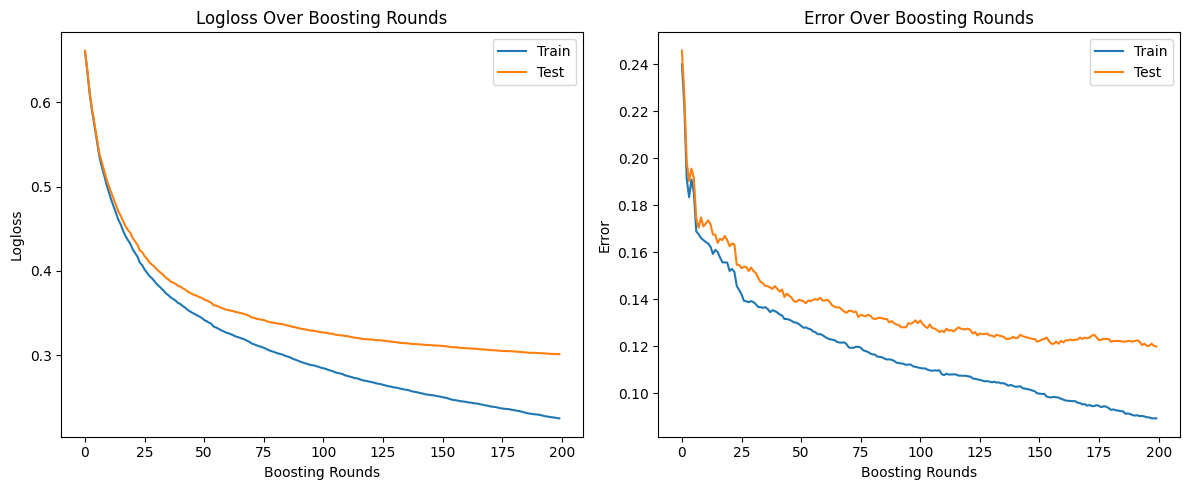

Final Model Test Accuracy: 0.8801


In [64]:
# Define the hyperparameter grid with ranges for random search
param_distributions = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'gamma': [0, 0.1, 0.2],
    'reg_alpha': [0, 0.1, 1],
    'reg_lambda': [1, 0.1, 0]
}

# Initialize the XGBoost classifier model with eval_metric in the initialization
xgb_model = XGBClassifier(eval_metric='logloss')

# Use RandomizedSearchCV for hyperparameter tuning
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_distributions,
    n_iter=50,
    cv=3,
    n_jobs=-1,
    random_state=42,
    scoring='accuracy',
    verbose=1
)

# Split the resampled dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Fit the model using random search for hyperparameter tuning
random_search.fit(X_train, y_train)

# Get the best parameters and the best score
best_params = random_search.best_params_
best_score = random_search.best_score_

# Print the best hyperparameters and score
print(f"Best Hyperparameters: {best_params}")
print(f"Best Cross-Validation Accuracy: {best_score:.4f}")

# Prepare the final model with early stopping, include eval_metric in the initialization
final_xgb_model = XGBClassifier(**best_params, eval_metric='logloss')

# Set up evaluation results to track training progress
eval_results = {}


# Prepare the final model with early stopping
final_xgb_model = XGBClassifier(**best_params, eval_metric=['logloss', 'error'])

# Train the final model
final_xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=False
)

# Get the evaluation results
results = final_xgb_model.evals_result()

# Plot the evaluation metrics (logloss and error) over boosting rounds
plt.figure(figsize=(12, 5))

# Plot logloss for both training and validation sets
plt.subplot(1, 2, 1)
plt.plot(results['validation_0']['logloss'], label='Train')
plt.plot(results['validation_1']['logloss'], label='Test')
plt.xlabel('Boosting Rounds')
plt.ylabel('Logloss')
plt.title('Logloss Over Boosting Rounds')
plt.legend()

# Plot error for both training and validation sets
plt.subplot(1, 2, 2)
plt.plot(results['validation_0']['error'], label='Train')
plt.plot(results['validation_1']['error'], label='Test')
plt.xlabel('Boosting Rounds')
plt.ylabel('Error')
plt.title('Error Over Boosting Rounds')
plt.legend()

plt.tight_layout()
plt.show()

# Print final model performance
y_pred = final_xgb_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Final Model Test Accuracy: {accuracy:.4f}")


The plots display the logloss and error over boosting rounds for both the training and test datasets. In the logloss plot, we see a consistent decline for both the training and test datasets as the number of boosting rounds increases, indicating that the model is learning and improving its performance by reducing the error in predictions. However, the test set logloss decreases at a slower pace compared to the training set, which may indicate slight overfitting as the model fits the training data more closely than the test data. In the error plot, both the training and test errors drop significantly in the initial boosting rounds, but the test error stabilizes at a higher value than the training error, again suggesting possible overfitting. The final test error stabilizes, indicating the model is not deteriorating with additional boosting rounds, but the gap between training and test performance should be monitored.

### Model Evaluation (Accuracy, Precision, Recall, etc.)

In [65]:
# Make predictions on the test data
y_pred = final_xgb_model.predict(X_test)  # Predicted class labels
y_pred_proba = final_xgb_model.predict_proba(X_test)[:, 1]  # Predicted probabilities for the positive class (1)

# Evaluate the model's performance using various metrics
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Print the evaluation metrics
print(f'Accuracy: {accuracy:.2f}')
print(f'Recall: {recall:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Confusion Matrix:\n{conf_matrix}')

Accuracy: 0.88
Recall: 0.92
Precision: 0.86
Confusion Matrix:
[[1396  273]
 [ 138 1620]]


### Feature Importance Analysis

By looking at feature importance, we can understand which features are driving the predictions. This helps interpret the model's decisions and gives insight into which variables are the most impactful.

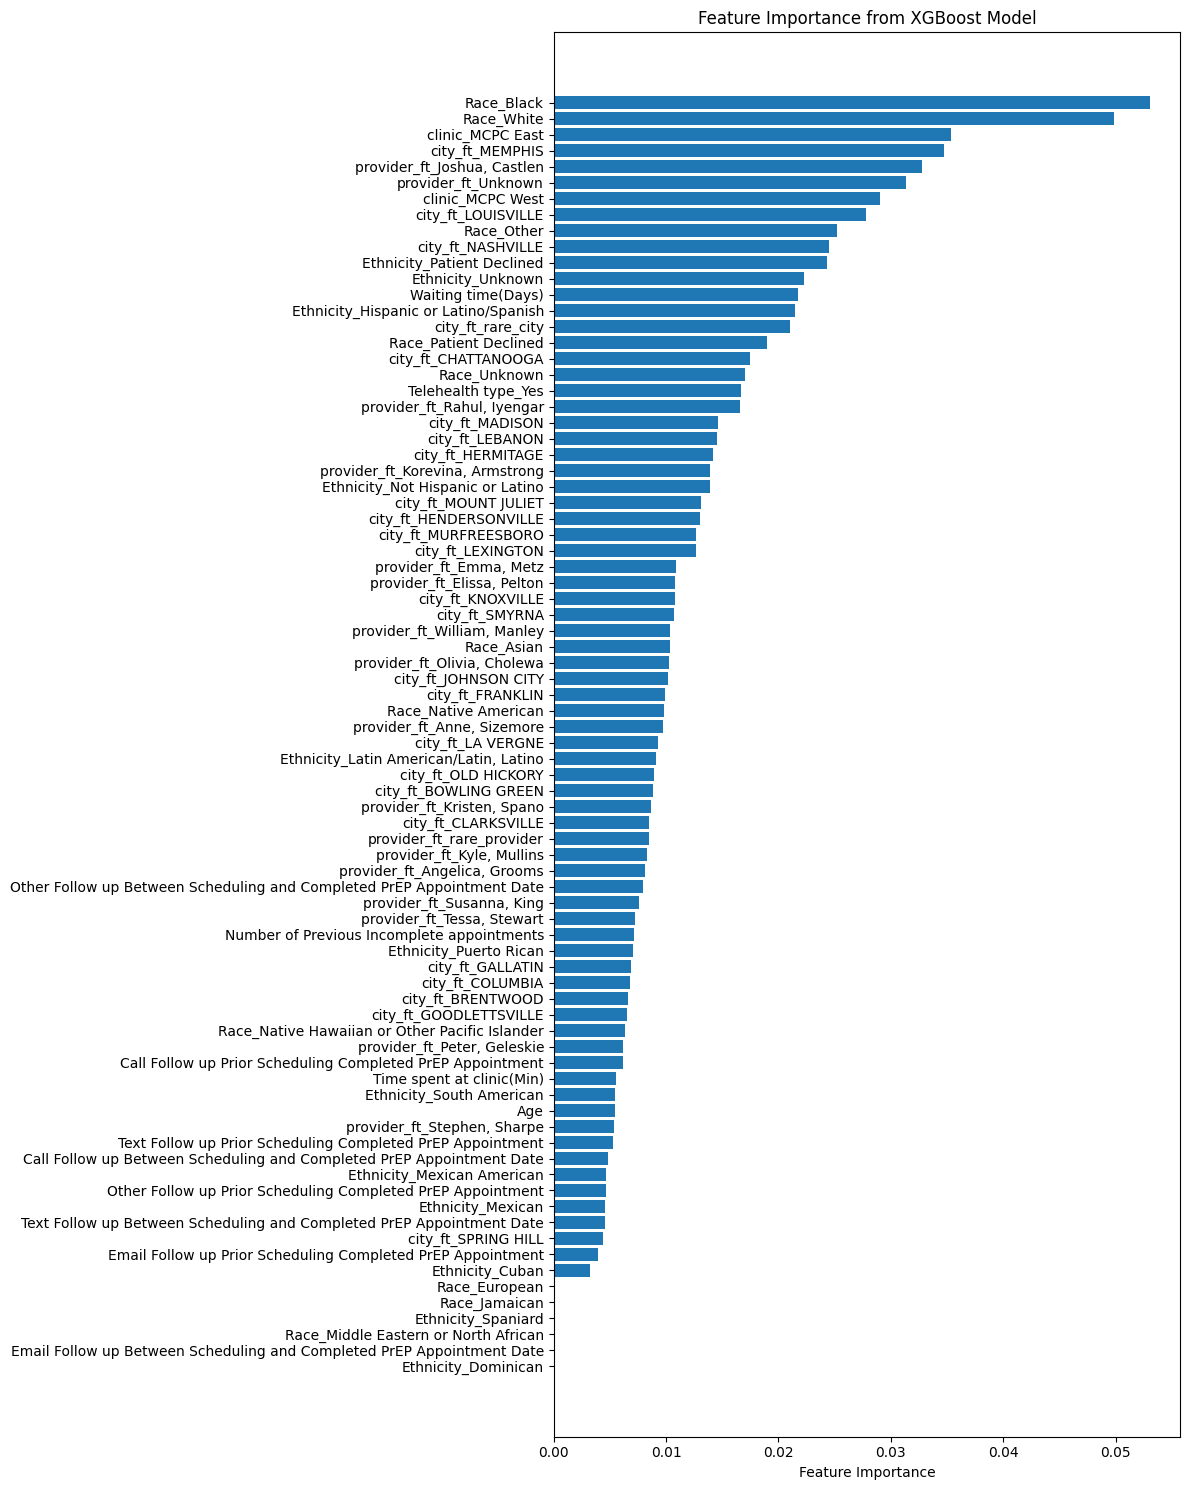

In [66]:
# Plot the feature importance using XGBoost's built-in method
xgb_importances = final_xgb_model.feature_importances_

# Sort and plot feature importance
sorted_idx = np.argsort(xgb_importances)
plt.figure(figsize=(12, 15))  # Increase figure size for better readability
plt.barh(range(len(sorted_idx)), xgb_importances[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), X_train.columns[sorted_idx])
plt.xlabel('Feature Importance')
plt.title('Feature Importance from XGBoost Model')

# Apply tight layout to avoid overlap of labels
plt.tight_layout()
plt.show()

The features at the top which are "Race_Black," "Race_White," and "clinic_MCPC East," are the features which have the most influence on the model's predictions. These features are used more frequently or effectively in the trees to make accurate predictions.
Features near the bottom, such as "Ethnicity_Dominican," "Email Follow up Between Scheduling and Completed PrEP Appointment Date," and "Race_Middle Eastern or North African," have very little influence on the model's performance. The model uses them less frequently or they don’t provide much predictive power.
The graph is sorted in descending order of feature importance, which makes it easy to see which features contribute the most to the model.

### SHAP Analysis for Model Explainability

The SHAP summary plot provides a global view of feature importance and how feature values impact model predictions. 

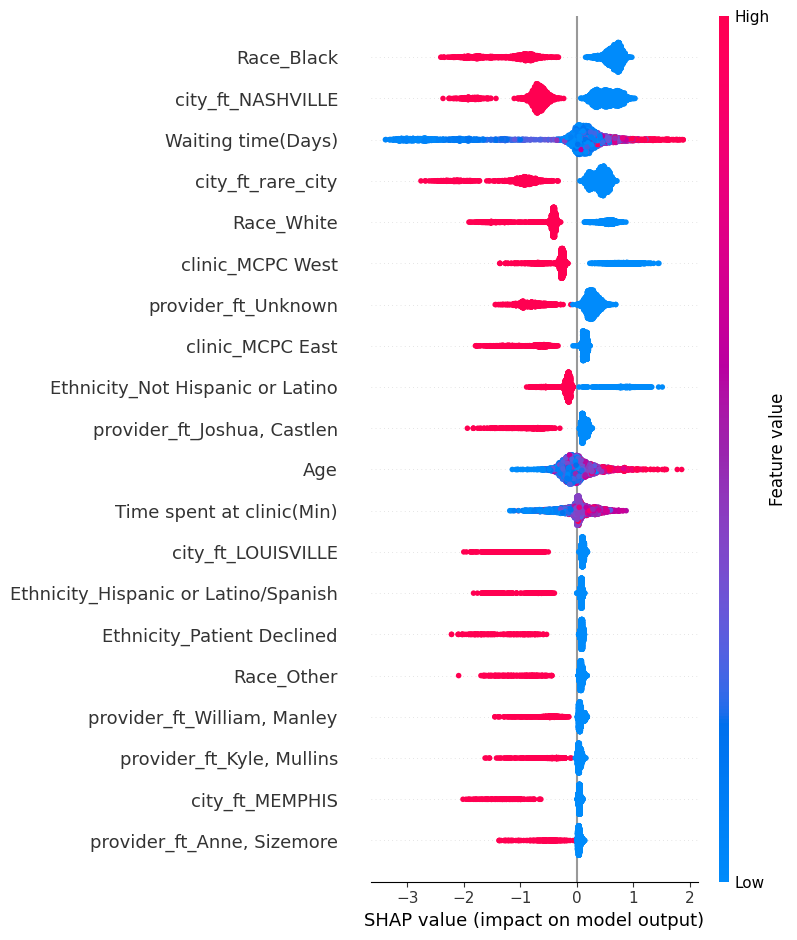

In [67]:
# Initialize SHAP explainer with the trained XGBoost model
explainer = shap.TreeExplainer(final_xgb_model)

# Calculate SHAP values for the test dataset
shap_values = explainer.shap_values(X_test)

# Plot summary plot for SHAP values (global feature importance)
shap.summary_plot(shap_values, X_test, feature_names=X_test.columns)

"Race_Black" and "city_ft_NASHVILLE" have a strong positive influence on the model’s predictions for higher outcomes.
"Waiting time(Days)" shows that longer waiting times tend to increase the predicted outcome, while shorter waiting times have a mixed impact.
Some features, like "provider_ft_William, Manley" and "provider_ft_Anne, Sizemore," have relatively lower and more uniform impacts on the predictions, meaning they contribute less to the overall predictions of the model.

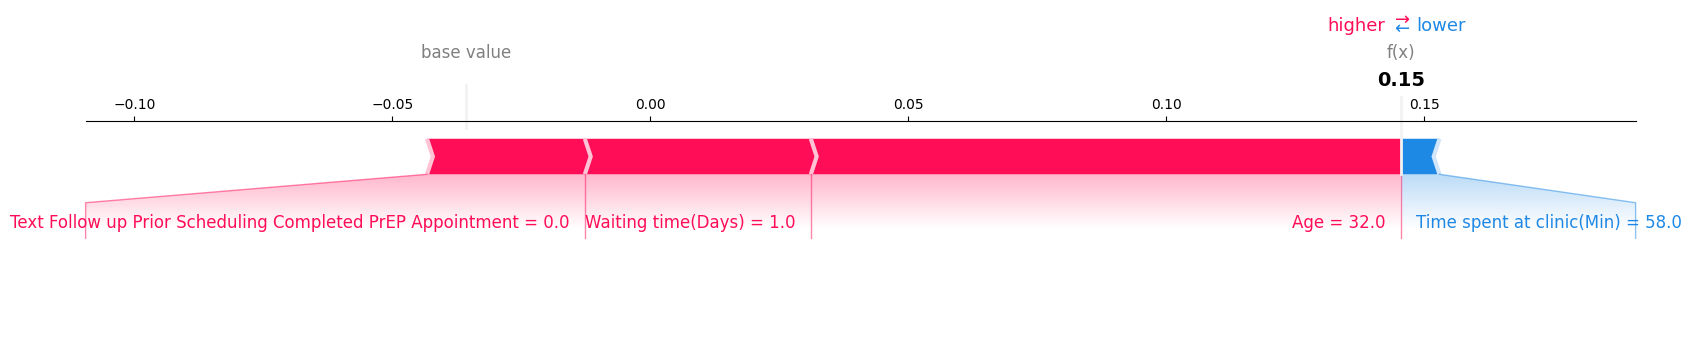

In [68]:
shap_values_top_features = shap_values[:, :4]

# Generate the force plot for the top N features
shap.force_plot(explainer.expected_value, shap_values[0, :4], X_test.iloc[0, :4], matplotlib=True)

The SHAP force plot explains how the top 4 selected features contribute to an individual prediction. The base value represents the average model output, and the prediction moves either higher or lower based on the contributions of the features. In this plot, "Text Follow up Prior Scheduling Completed PrEP Appointment = 0.0" and "Waiting time(Days) = 1.0" are pushing the prediction higher (colored red), meaning they increase the predicted outcome, while "Age = 32.0" and "Time spent at clinic(Min) = 58.0" push the prediction slightly lower (colored blue), decreasing the predicted outcome. The final predicted value, represented as f(x), is 0.15. We have selected 4 features to avoid overlapping names in teh plot.

### Partial Dependence Plot

Partial dependence plots are useful because they help visualize the relationship between specific features and the predicted outcome, while holding all other features constant. This allows you to see how changes in a single feature impact the model's predictions, providing insights into the model's behavior and feature importance. They are particularly valuable for understanding non-linear relationships, detecting feature interactions, and offering interpretability in complex models by showing how a feature influences predictions across its range of values.

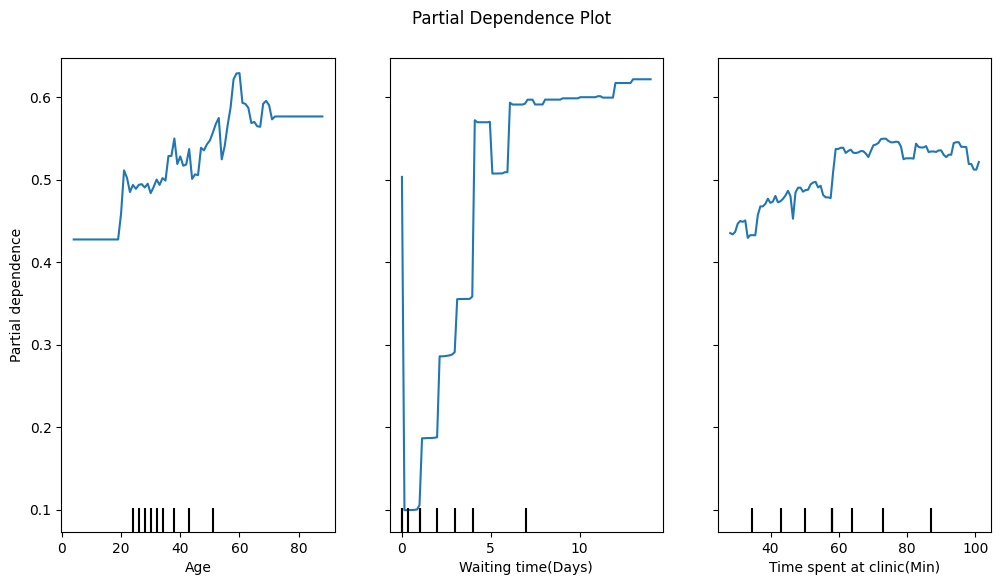

In [69]:
# Plot partial dependence for features
features_to_plot = [0, 1, 2]  # Features to plot
fig, ax = plt.subplots(figsize=(12, 6))
PartialDependenceDisplay.from_estimator(final_xgb_model, X_train, features_to_plot, ax=ax)
plt.suptitle('Partial Dependence Plot')
plt.subplots_adjust(top=0.9) 
plt.show()


In the plot, three features are displayed: "Age," "Waiting time(Days)," and "Time spent at clinic(Min)." The y-axis represents the predicted probability (partial dependence) of the target, while the x-axis shows the values of the corresponding feature. For "Age," the plot shows that as age increases, the probability gradually increases, with some fluctuations around the mid-40s to 60s. "Waiting time(Days)" shows a steep increase in probability with longer waiting times, stabilizing after a few days. "Time spent at clinic(Min)" has a generally upward trend, indicating that spending more time at the clinic slightly increases the predicted probability, though there are small variations. These plots help visualize the relationship between each feature and the model's prediction.

### ROC Curve

The Receiver Operating Characteristic (ROC) curve plots the True Positive Rate (Sensitivity) against the False Positive Rate (1 - Specificity) at various threshold settings. The curve helps evaluate the performance of a binary classifier. A model with a curve closer to the top left corner is better, indicating higher true positives with fewer false positives. The diagonal line represents random guessing, and the further the ROC curve is above this line, the better the model's performance. The area under the curve (AUC) provides a single metric summarizing the model's ability to distinguish between classes, with a value closer to 1 indicating better performance.

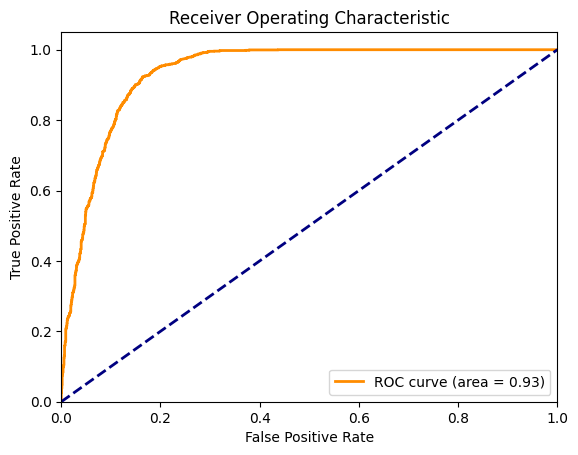

In [70]:
# Compute the Receiver Operating Characteristic (ROC) curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')  # ROC curve
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line representing random guessing
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

An AUC of 0.93 shows that the model performs well in distinguishing between the classes.

### LightGBM Model training and Evaluation

LightGBM is a gradient boosting framework that builds decision trees in a sequential manner, where each tree is designed to correct the errors of the previous trees. It follows the principles of gradient boosting, but with optimizations that make it faster and more efficient than other gradient-boosting algorithms.

LightGBM uses a leaf-wise growth strategy, as opposed to XGBoost’s level-wise growth. This approach grows the tree by splitting the leaf with the highest loss, which often results in smaller, more efficient trees that can achieve higher accuracy.

In [71]:
import re

# Function to clean feature names by removing special characters
def clean_feature_names(df):
    df.columns = [re.sub(r'\W+', '_', col) for col in df.columns]  # Replace non-alphanumeric characters with an underscore
    return df

# Apply the function to your feature matrix (X_train and X_test)
X_train = clean_feature_names(X_train)
X_test = clean_feature_names(X_test)

# Train the LightGBM model again
from lightgbm import LGBMClassifier
model = LGBMClassifier()
model.fit(X_train, y_train)


[LightGBM] [Info] Number of positive: 6809, number of negative: 6898
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004818 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 779
[LightGBM] [Info] Number of data points in the train set: 13707, number of used features: 75
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.496753 -> initscore=-0.012986
[LightGBM] [Info] Start training from score -0.012986


LGBMClassifier()

In [72]:
# Make predictions on the test data
y_pred = model.predict(X_test)

y_pred_proba = model.predict_proba(X_test)[:, 1]

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

# Calculate AUC-ROC
auc_score = roc_auc_score(y_test, y_pred_proba)
print(f'AUC-ROC: {auc_score:.4f}')

# Print detailed classification report
print(classification_report(y_test, y_pred))


Accuracy: 0.8751
AUC-ROC: 0.9315
              precision    recall  f1-score   support

           0       0.91      0.82      0.86      1669
           1       0.84      0.93      0.88      1758

    accuracy                           0.88      3427
   macro avg       0.88      0.87      0.87      3427
weighted avg       0.88      0.88      0.87      3427



LightGBM model is performing quite well, with an accuracy of 87.5% and an AUC-ROC of 93.15%. The precision, recall, and F1-scores are well-balanced, particularly for class 1 (shipment occurred), where the model shows high recall (93%), meaning it’s very good at identifying the positive class.